In [1]:
import anndata
import scvelo as scv
import matplotlib.pyplot as plt
from spvelo import *

In [2]:
def avg_latent_time(adata, marker_num=10, ct_key='cluster_annotations', time_key='latent_time_velovi'):
    scv.tl.rank_velocity_genes(adata, groupby=ct_key)
    
    adata.obs['latent_time'] = [0]*adata.shape[0]
    for ct in ['core', 'transitory', 'edge']:
        markers = pd.DataFrame(adata.uns['rank_velocity_genes']['names'])[:marker_num][ct].tolist()
        adata.obs.loc[adata.obs[ct_key]==ct, 'latent_time'] = np.mean(adata[adata.obs[ct_key] == ct, markers].layers[time_key], axis=1).tolist()
    
    return adata

In [3]:
adata = anndata.read_h5ad('/gpfs/gibbs/pi/zhao/wl545/spatial_velo_sorted/OSCC/batch_integration/seed0/adatas/wonc_prefilter_mnn_mmd.h5ad')
adata = adata[adata.obs.batch=='5']
scv.pp.neighbors(adata)

computing neighbors
    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


In [4]:
import scanpy as sc
import pandas as pd
import numpy as np
#dpt given core as root cells
sc.tl.diffmap(adata)
lst = []
for i in range(adata.obsm["X_diffmap"].shape[1]):
    x = adata.obsm["X_diffmap"][:, i]
    lst.append(np.std(x))
#adata.uns["iroot"] = adata.obsm["X_diffmap"][:, np.array(lst).argmax()].argmin()
adata.uns["iroot"] = np.flatnonzero(adata.obs["cluster_annotations"] == "core")[0]
sc.tl.dpt(adata)

In [5]:
#pseudotime from velocity
scv.tl.velocity_graph(adata)
scv.tl.velocity_pseudotime(adata)
    
#get averaged latent time
adata = avg_latent_time(adata, marker_num=5)

computing velocity graph (using 1/32 cores)


  0%|          | 0/942 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
ranking velocity genes
    finished (0:00:00) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


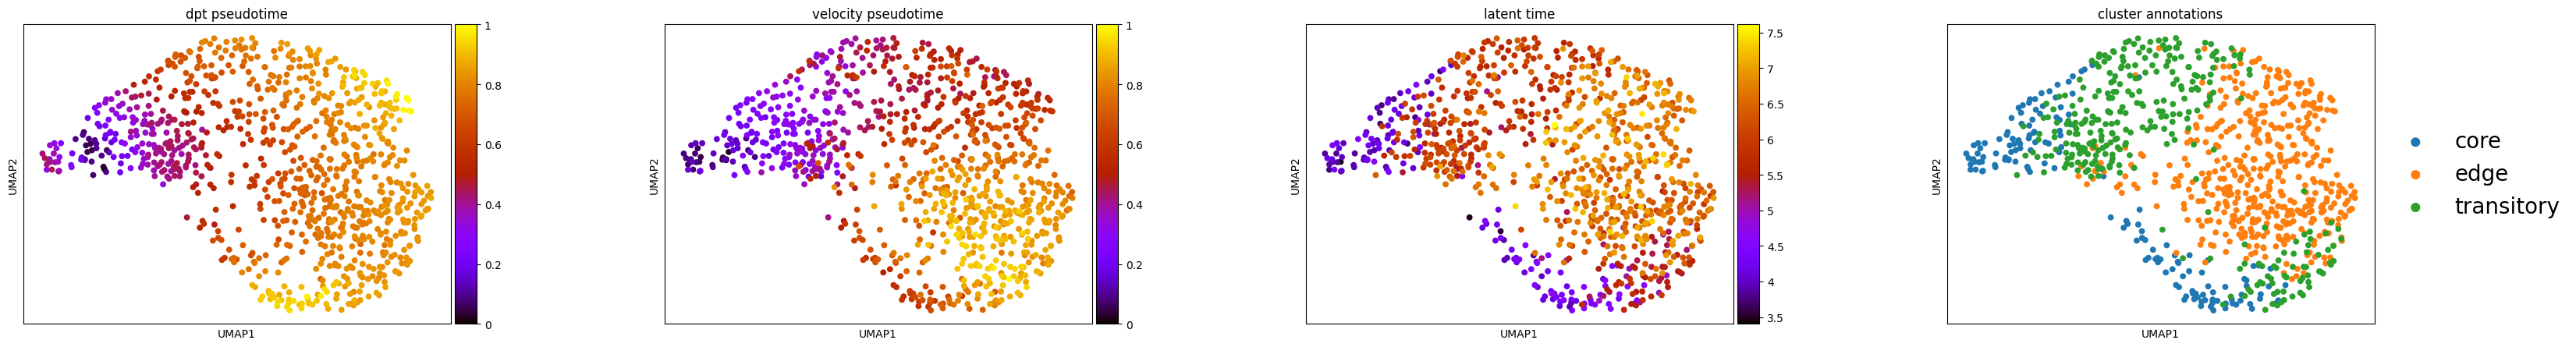

In [6]:
sc.pl.scatter(adata, basis="umap", 
              color=["dpt_pseudotime", "velocity_pseudotime", "latent_time", "cluster_annotations"], 
              color_map="gnuplot", legend_fontsize=20)

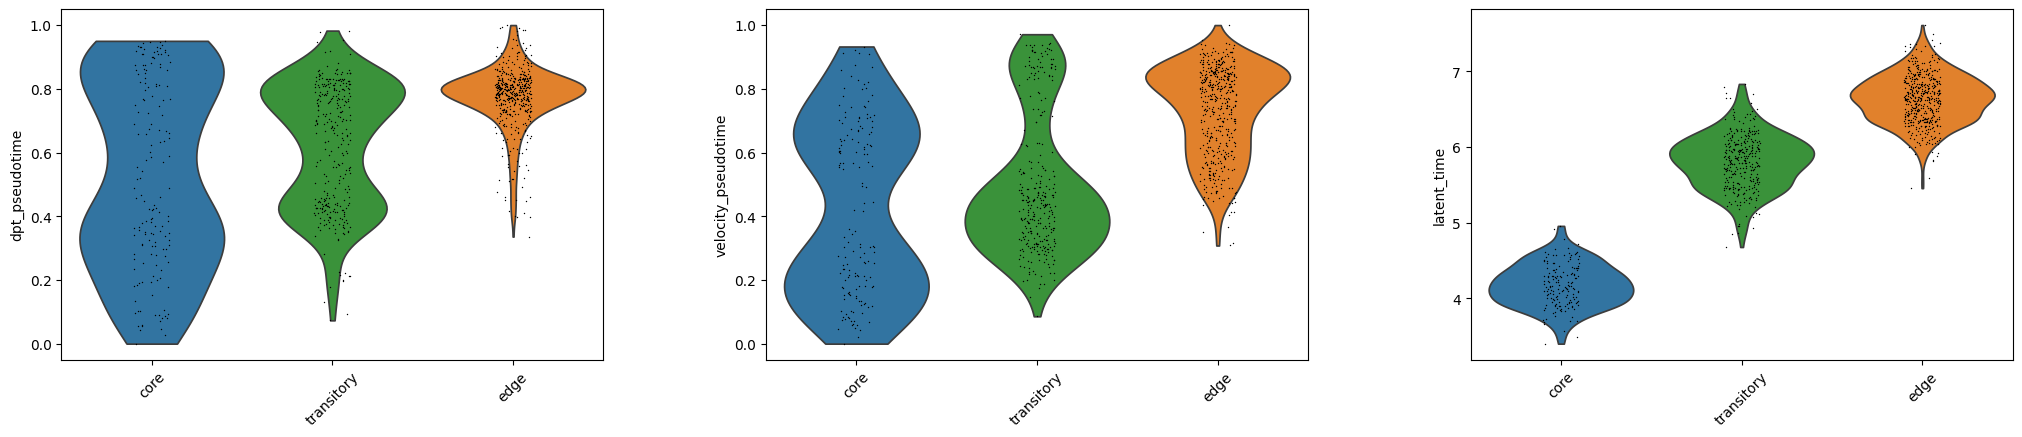

In [7]:
sc.pl.violin(adata,keys=["dpt_pseudotime", "velocity_pseudotime", "latent_time"],groupby="cluster_annotations",
             rotation=45, order=["core","transitory","edge"])

In [8]:
# velocity coherence score, from LatentVelo
def nn_velo(adata, layer=True, batch_key = 'batch', vkey = 'velocity', neighbor_key = 'neighbors', all=False, plot=False):
    from itertools import combinations
    from sklearn.metrics.pairwise import cosine_similarity
    from latentvelo.utils import paired_cosine_similarity
    from scipy.stats import spearmanr, pearsonr, sem
    
    if not all:
        index = np.random.choice(adata.shape[0], size = 100, replace=False)
    else:
        index = np.arange(adata.shape[0])

    values = []
    batch_ids = np.unique(adata.obs[batch_key])
    for i in range(len(index)):
        batch_i = [adata[adata.uns[neighbor_key]['indices'][index[i]][adata[adata.uns[neighbor_key]['indices'][index[i]]].obs[batch_key] == b]] for b in batch_ids]
        
        for (b1, b2) in list(combinations(np.arange(len(batch_ids)), 2)):
            
            if batch_i[b1].shape[0] > 0 and batch_i[b2].shape[0] > 0:
                if layer:
                    values.append(paired_cosine_similarity(batch_i[b1].layers[vkey].mean(0)[None], batch_i[b2].layers[vkey].mean(0)[None])[0])
                else:
                    values.append(paired_cosine_similarity(batch_i[b1].obsm[vkey].mean(0)[None], batch_i[b2].obsm[vkey].mean(0)[None])[0])
    
    values = np.array(values)
    
    if plot:
        plt.bar(np.arange(len(values)), values)
    
    return np.mean(values), sem(values), values

In [9]:
from spvelo.eval_util import get_mnn
mean, var, cos = {}, {}, {}
for method in ['prefilter_mnn_mmd', 'std_ltv', 'annot_ltv']:
    adata = anndata.read_h5ad(f'/gpfs/gibbs/pi/zhao/wl545/spatial_velo_sorted/OSCC/batch_integration/seed0/adatas/wonc_{method}.h5ad')
    get_mnn(adata, batch_key='batch', n_bnn_neighbors=30, is_ot=False, use_rep='X_pca')
    mean[method], var[method], cos[method] = nn_velo(adata, layer=True, batch_key = 'batch', vkey = 'velocity', 
                                                     neighbor_key = 'neighbors', all=False, plot=False)

use_rep : X_pca
batch_pair_list : [['1', '2'], ['1', '3'], ['1', '4'], ['1', '5'], ['1', '6'], ['1', '7'], ['1', '8'], ['1', '9'], ['1', '10'], ['1', '11'], ['1', '12'], ['2', '3'], ['2', '4'], ['2', '5'], ['2', '6'], ['2', '7'], ['2', '8'], ['2', '9'], ['2', '10'], ['2', '11'], ['2', '12'], ['3', '4'], ['3', '5'], ['3', '6'], ['3', '7'], ['3', '8'], ['3', '9'], ['3', '10'], ['3', '11'], ['3', '12'], ['4', '5'], ['4', '6'], ['4', '7'], ['4', '8'], ['4', '9'], ['4', '10'], ['4', '11'], ['4', '12'], ['5', '6'], ['5', '7'], ['5', '8'], ['5', '9'], ['5', '10'], ['5', '11'], ['5', '12'], ['6', '7'], ['6', '8'], ['6', '9'], ['6', '10'], ['6', '11'], ['6', '12'], ['7', '8'], ['7', '9'], ['7', '10'], ['7', '11'], ['7', '12'], ['8', '9'], ['8', '10'], ['8', '11'], ['8', '12'], ['9', '10'], ['9', '11'], ['9', '12'], ['10', '11'], ['10', '12'], ['11', '12']]
use_rep : X_pca
batch_pair_list : [['1', '2'], ['1', '3'], ['1', '4'], ['1', '5'], ['1', '6'], ['1', '7'], ['1', '8'], ['1', '9'], ['1', '10

In [10]:
lst = []
for method in ['prefilter_mnn_mmd', 'std_ltv', 'annot_ltv']:
    a = pd.DataFrame(cos[method], columns=['score'])
    a['method'] = method
    lst.append(a)
df = pd.concat(lst)
df

,score,method
0,0.825076,prefilter_mnn_mmd
1,0.818215,prefilter_mnn_mmd
2,0.815093,prefilter_mnn_mmd
3,0.584328,prefilter_mnn_mmd
4,0.772625,prefilter_mnn_mmd
...,...,...
1960,0.706188,annot_ltv
1961,0.692905,annot_ltv
1962,0.702165,annot_ltv
1963,0.687958,annot_ltv


One-sided t-test p-value between spVelo and LatentVelo(standard): 1.3476258261173448e-259
One-sided t-test p-value between spVelo and LatentVelo(annotated): 3.0320137321254295e-59


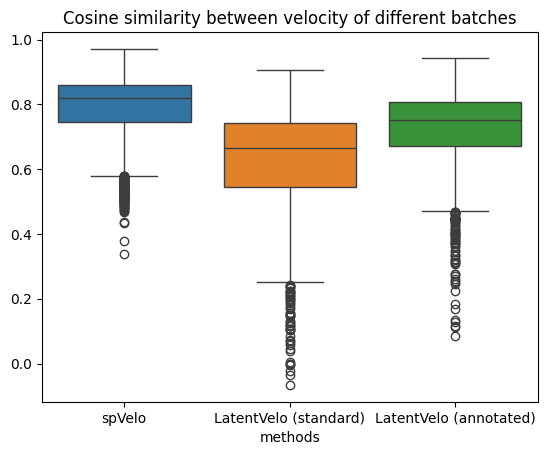

In [11]:
import seaborn as sns
from scipy.stats import ttest_ind
import starbars

stat1, p_value1 = ttest_ind(cos['prefilter_mnn_mmd'], cos['std_ltv'], alternative='greater')
print(f"One-sided t-test p-value between spVelo and LatentVelo(standard): {p_value1}")
stat2, p_value2 = ttest_ind(cos['prefilter_mnn_mmd'], cos['annot_ltv'], alternative='greater')
print(f"One-sided t-test p-value between spVelo and LatentVelo(annotated): {p_value2}")

a = {'prefilter_mnn_mmn': cos['prefilter_mnn_mmd'], 'std_ltv': cos['std_ltv'], 'annot_ltv': cos['annot_ltv']}
sns.boxplot(a)
plt.xticks(ticks=[0, 1, 2], labels=['spVelo', 'LatentVelo (standard)', 'LatentVelo (annotated)'])
plt.xlabel('methods')
plt.title('Cosine similarity between velocity of different batches')
plt.show()

In [12]:
# Plot state variance funtions, from VeloVAE
def histeq(x, perc=0.95, Nbin=101):
    x_ub = np.quantile(x, perc)
    x_lb = x.min()
    delta_x = (x_ub - x_lb)/(Nbin-1)
    bins = [x_lb+i*delta_x for i in range(Nbin)]+[x.max()]
    pdf_x, edges = np.histogram(x, bins, density=True)
    px, edges = np.histogram(x, bins, density=False)

    # Perform histogram equalization
    cdf = np.concatenate(([0], np.cumsum(px)))
    cdf = cdf/cdf[-1]
    x_out = np.zeros((len(x)))
    for i in range(Nbin):
        mask = (x >= bins[i]) & (x < bins[i+1])
        x_out[mask] = (cdf[i] + (x[mask]-bins[i])*pdf_x[i])*np.abs(x.max())
    return x_out

In [13]:
def _plot_heatmap(ax,
                  vals,
                  X_embed,
                  colorbar_name,
                  colorbar_ticklabels=None,
                  markersize=5,
                  cmap='plasma',
                  show_color_bar=True,
                  axis_off=True):
    """General heatmap plotting helper function.
    """
    import matplotlib
    ax.scatter(X_embed[:, 0],
               X_embed[:, 1],
               s=markersize,
               c=vals,
               cmap=cmap,
               edgecolors='none')
    vmin = np.quantile(vals, 0.01)
    vmax = np.quantile(vals, 0.99)
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
    cbar = plt.colorbar(sm, ax=ax)
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel(colorbar_name, rotation=270, fontsize=24, labelpad=25)
    if colorbar_ticklabels is not None:
        if len(colorbar_ticklabels) == 2:
            cbar.ax.get_yaxis().labelpad = 5
        cbar.set_ticks(np.linspace(vmin, vmax, len(colorbar_ticklabels)))
        cbar.ax.set_yticklabels(colorbar_ticklabels, fontsize=12)
    if axis_off:
        ax.axis("off")
    cbar.ax.yaxis.set_visible(True)
    return ax

In [14]:
def plot_state_var(std_z,
                   X_embed,
                   z=None,
                   hist_eq=True,
                   cmap='viridis',
                   save=None):
    """Plots cell state variance (in the form of coefficient of variation) as a heatmap. From VeloVAE.

    Args:
        std_z (:class:`numpy.ndarray`):
            Standard deviation of cell state, assuming diagonal covariance, (N, dim z)
        X_embed (:class:`numpy.ndarray`):
            2D coordinates for visualization, (N,2)
        z (:class:`numpy.ndarray`, optional):
            Mean cell state, (N, dim z). Defaults to None.
        hist_eq (bool, optional):
            Whether to perform histogram equalization. Defaults to True.
        cmap (str, optional):
            Colormap name. Defaults to 'viridis'.
        save (str, optional):
            Figure name for saving (including path). Defaults to None.
    """
    z_norm = np.ones((std_z.shape)) if z is None else np.linalg.norm(z, axis=1).reshape(-1, 1) + 1e-10
    diff_entropy = 0.5*np.sum(np.log(std_z/z_norm), 1) + 0.5*std_z.shape[1]*(1+np.log(2*np.pi))
    if hist_eq:
        diff_entropy = histeq(diff_entropy, Nbin=len(diff_entropy)//50)

    fig, ax = plt.subplots(figsize=(12, 6))
    ax = _plot_heatmap(ax, diff_entropy, X_embed, "State Uncertainty", ["0.00", "0.25", "0.50", "0.75", "1.00"], cmap=cmap, axis_off=True)
    if save:
        plt.savefig(save)
    plt.show()

[rank: 0] Global seed set to 0


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


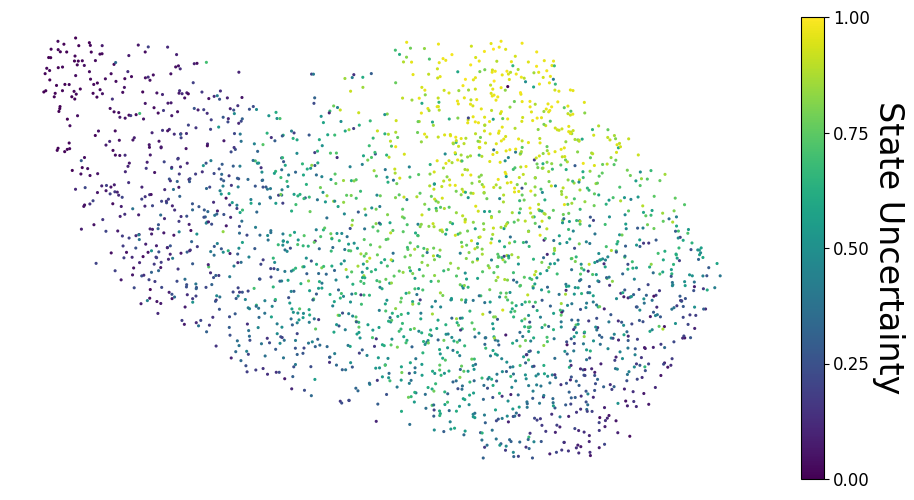

In [15]:
from spvelo._utils import load_obj
vae = load_obj('/gpfs/gibbs/pi/zhao/wl545/spatial_velo_sorted/OSCC/batch_integration/seed0/models/wonc_prefilter_mnn_mmd.pkl')
adata = vae.adata
qz_m, qz_v = vae.get_latent_representation(return_dist=True)
adata.obsm['qz_v'] = qz_v
bdata = adata[adata.obs.batch=='9',:].copy()
plot_state_var(std_z=bdata.obsm['qz_v'], X_embed=bdata.obsm['X_umap'], z=None, hist_eq=True, cmap='viridis')